C:\anaconda3\envs\study\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


LL restr.:   -5047.205  rhobar: -0.002  Parameters: 10
LL unrestr.: -5039.396  rhobar: -0.002  Parameters: 11
Likelihood ratio: 15.618
Output files:
boxcox_restricted~09.html
boxcox_unrestricted~09.html


C:\Users\Yuzhu\AppData\Local\Temp\ipykernel_79616\2521996667.py:113: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  V = betaValues['B_CAR_TIME'] * boxcox(tt_scaled,np.float(betaValues['LAMBDA']))


TypeError: float() argument must be a string or a number, not 'Times'

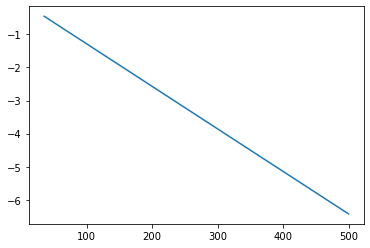

In [3]:
# Translated to .py by Marti Montesinos
# Adapted to pandas biogeme by Michel Bierlaire
# Sun Oct 28 19:43:29 2018

import pandas as pd
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.models import boxcox
from biogeme.expressions import Beta, DefineVariable, log
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("swissmetro.dat",'\t')
database = db.Database("swissmetro",df)
pd.options.display.float_format = '{:.3g}'.format
globals().update(database.variables)


exclude = ((  PURPOSE   !=  1  ) * (  PURPOSE   !=  3  ) + (  CHOICE   ==  0  ) + (  AGE == 6  ))>0
database.remove(exclude)


#Parameters to be estimated
# Arguments:
#   1  Name for report. Typically, the same as the variable
#   2  Starting value
#   3  Lower bound
#   4  Upper bound
#   5  0: estimate the parameter, 1: keep it fixed
ASC_CAR	 = Beta('ASC_CAR',0,None,None,0)
ASC_SBB	 = Beta('ASC_SBB',0,None,None,1)
ASC_SM	 = Beta('ASC_SM',0,None,None,0)
B_CAR_COST	 = Beta('B_CAR_COST',0,None,None,0)
B_CAR_TIME	 = Beta('B_CAR_TIME',0,None,None,0)
B_GA	 = Beta('B_GA',0,None,None,0)
B_HE	 = Beta('B_HE',0,None,None,0)
B_SM_COST	 = Beta('B_SM_COST',0,None,None,0)
B_SM_TIME	 = Beta('B_SM_TIME',0,None,None,0)
B_TRAIN_COST	 = Beta('B_TRAIN_COST',0,None,None,0)
B_TRAIN_TIME	 = Beta('B_TRAIN_TIME',0,None,None,0)
LAMBDA	 = Beta('LAMBDA',0.2,None,None,0)

# Define here arithmetic expressions for name that are not directly 
# available from the data

SENIOR  = DefineVariable('SENIOR', AGE   ==  5 ,database)
CAR_AV_SP  = DefineVariable('CAR_AV_SP', CAR_AV    *  (  SP   !=  0  ),database)
SM_COST  = DefineVariable('SM_COST', SM_CO   * (  GA   ==  0  ),database)
TRAIN_AV_SP  = DefineVariable('TRAIN_AV_SP', TRAIN_AV    *  (  SP   !=  0  ),database)
TRAIN_COST  = DefineVariable('TRAIN_COST', TRAIN_CO   * (  GA   ==  0  ),database)
TRAIN_HE_SCALED = DefineVariable('TRAIN_HE_SCALED',\
                                 TRAIN_HE / 100.0,database)
SM_HE_SCALED = DefineVariable('SM_HE_SCALED',\
                                 SM_HE / 100.0,database)
TRAIN_TT_SCALED = DefineVariable('TRAIN_TT_SCALED',\
                                 TRAIN_TT / 100.0,database)
TRAIN_COST_SCALED = DefineVariable('TRAIN_COST_SCALED',\
                                   TRAIN_COST / 100,database)
SM_TT_SCALED = DefineVariable('SM_TT_SCALED', SM_TT / 100.0,database)
SM_COST_SCALED = DefineVariable('SM_COST_SCALED', SM_COST / 100,database)
CAR_TT_SCALED = DefineVariable('CAR_TT_SCALED', CAR_TT / 100,database)
CAR_CO_SCALED = DefineVariable('CAR_CO_SCALED', CAR_CO / 100,database)

av = {3: CAR_AV_SP,1: TRAIN_AV_SP,2: SM_AV}

# Utilities restricted
M1_Car_SP = ASC_CAR + B_CAR_TIME * CAR_TT_SCALED + B_CAR_COST * CAR_CO_SCALED
M1_SBB_SP = ASC_SBB + B_TRAIN_COST * TRAIN_COST_SCALED + B_HE * TRAIN_HE_SCALED + B_GA * GA +  B_TRAIN_TIME   * TRAIN_TT_SCALED
M1_SM_SP = ASC_SM + B_SM_TIME * SM_TT_SCALED + B_SM_COST * SM_COST_SCALED + B_HE * SM_HE_SCALED + B_GA * GA
M1_V = {3: M1_Car_SP,1: M1_SBB_SP,2: M1_SM_SP}
M1_logprob = models.loglogit(M1_V,av,CHOICE)


# Utilities unrestricted
M2_Car_SP = ASC_CAR + B_CAR_TIME * boxcox(CAR_TT_SCALED,LAMBDA) + B_CAR_COST * CAR_CO_SCALED 
M2_SBB_SP = ASC_SBB + B_TRAIN_COST * TRAIN_COST_SCALED + B_HE * TRAIN_HE_SCALED + B_GA * GA +  B_TRAIN_TIME   * TRAIN_TT_SCALED
M2_SM_SP = ASC_SM + B_SM_TIME * SM_TT_SCALED + B_SM_COST * SM_COST_SCALED + B_HE * SM_HE_SCALED + B_GA * GA
M2_V = {3: M2_Car_SP,1: M2_SBB_SP,2: M2_SM_SP}
M2_logprob = models.loglogit(M2_V,av,CHOICE)


biogeme_M1  = bio.BIOGEME(database,M1_logprob)
biogeme_M1.modelName = "boxcox_restricted"
results_M1 = biogeme_M1.estimate()
ll_M1 = results_M1.data.logLike

biogeme_M2  = bio.BIOGEME(database,M2_logprob)
biogeme_M2.modelName = "boxcox_unrestricted"
results_M2 = biogeme_M2.estimate()
ll_M2 = results_M2.data.logLike

print(f"LL restr.:   {ll_M1:.3f}  rhobar: {results_M1.data.rhoBarSquare:.3f}  Parameters: {results_M1.data.nparam}")
print(f"LL unrestr.: {ll_M2:.3f}  rhobar: {results_M2.data.rhoBarSquare:.3f}  Parameters: {results_M2.data.nparam}")
lr = -2 * (ll_M1 - ll_M2)
print(f"Likelihood ratio: {lr:.3f}")
print("Output files:")
print(f"{results_M1.data.htmlFileName}")
print(f"{results_M2.data.htmlFileName}")

def utilLinear(tt):
    beta = ['B_CAR_TIME']
    betaValue = results_M1.getBetaValues(beta)
    return betaValue['B_CAR_TIME'] * tt / 100

def utilBoxCox(tt):
    tt_scaled = tt / 100
    betas = ['B_CAR_TIME','LAMBDA']
    betaValues = results_M2.getBetaValues(betas)
#     print(tt_scaled)
#     print(np.float(betaValues['LAMBDA']))
#     print(boxcox(tt_scaled,np.float(betaValues['LAMBDA'])))
    V = betaValues['B_CAR_TIME'] * boxcox(tt_scaled,np.float(betaValues['LAMBDA']))
    return V

travelTime = np.arange(35,500,0.5)
vl = [utilLinear(t) for t in travelTime]
vbc = [utilBoxCox(t) for t in travelTime]
# print(vbc)

fig, ax = plt.subplots()
ax.plot(travelTime,vl,label='Linear')
ax.plot(travelTime,vbc,label='Box-Cox')
ax.legend()
plt.xlabel("CAR travel time")
plt.ylabel("Utility of CAR")
plt.show()



In [5]:
r1 = results_M1.getEstimatedParameters()
r2 = results_M2.getEstimatedParameters()
cols_ex = ['Std err', 't-test', 'p-value']
print('Linear')
print(r1.loc[:, ~r1.columns.isin(cols_ex)])
print('\nBox-Cox')
print(r2.loc[:, ~r2.columns.isin(cols_ex)])

Linear
              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR      -0.529         0.158        -3.35      0.000807
ASC_SM       -0.126         0.116        -1.08         0.279
B_CAR_COST   -0.776          0.15        -5.18      2.26e-07
B_CAR_TIME    -1.29         0.162        -7.94         2e-15
B_GA          0.513         0.194         2.65       0.00806
B_HE         -0.535         0.101        -5.31       1.1e-07
B_SM_COST     -1.08        0.0828          -13             0
B_SM_TIME     -1.11         0.179        -6.19      6.04e-10
B_TRAIN_COST     -3           0.2          -15             0
B_TRAIN_TIME -0.866          0.12        -7.22      5.38e-13

Box-Cox
              Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR       -1.91         0.186        -10.2             0
ASC_SM       -0.143         0.117        -1.22         0.224
B_CAR_COST   -0.723         0.129        -5.58      2.41e-08
B_CAR_TIME    -1.52         0.111        -13.7             0
B_GA    